In [ ]:
!nvidia-smi

Thu Jan  2 15:56:14 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              14W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/weights


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/content/weights
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/weights/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/weights/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content/weights
/content/weights/weights


In [ ]:
import os

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/weights/groundingdino_swint_ogc.pth ; exist: True


In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model_GD = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/weights/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import groundingdino.datasets.transforms as T
from PIL import Image, ImageOps
import numpy as np
from typing import Tuple
import torch

def load_image_updated(image_path: str) -> Tuple[np.array, torch.Tensor]:
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_original = Image.open(image_path).convert("RGB")
    image_source = ImageOps.exif_transpose(image_original)
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

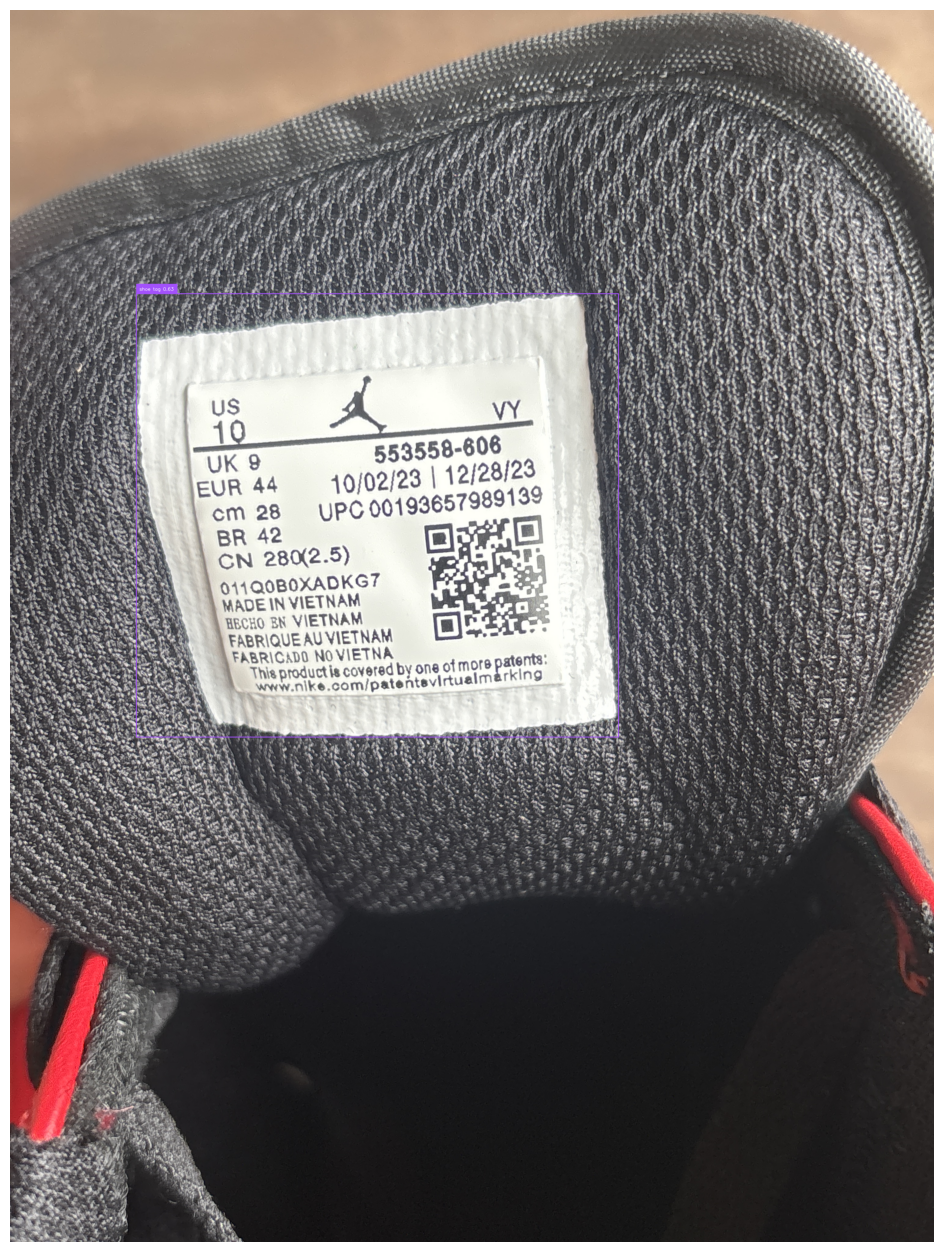

In [ ]:
import os
import supervision as sv
from groundingdino.util.inference import load_model, load_image, predict, annotate

IMAGE_PATH = "/content/data/T3.png"

TEXT_PROMPT = "Shoe Tag"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image_updated(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model_GD,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [30]:
boxes

tensor([[0.3978, 0.4102, 0.5219, 0.3597]])

In [ ]:
import os
from typing import List

def process_images_for_yolo(
    input_folder: str,
    output_folder: str,
    model,
    text_prompt: str = "Shoe Tag",
    box_threshold: float = 0.35,
    text_threshold: float = 0.25,
    class_id: int = 0
):
    """
    Processes images in a folder, extracts bounding boxes using a model, and saves them in YOLO format.

    :param input_folder: Path to the folder containing input images.
    :param output_folder: Path to the folder where YOLO labels will be saved.
    :param model: The loaded GroundingDINO model.
    :param text_prompt: Text prompt used for the model.
    :param box_threshold: Threshold for box predictions.
    :param text_threshold: Threshold for text predictions.
    :param class_id: Class ID to assign to all detected boxes (default is 0 for "Shoe Tag").
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over all images in the input folder
    for file_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, file_name)
        if not file_name.lower().endswith((".png", ".jpg", ".jpeg")):
            print(f"Skipping non-image file: {file_name}")
            continue

        try:
            # Load and process the image
            image_source, image = load_image_updated(input_path)

            # Run the model prediction
            boxes, logits, phrases = predict(
                model=model,
                image=image,
                caption=text_prompt,
                box_threshold=box_threshold,
                text_threshold=text_threshold
            )

            # Normalize boxes to YOLO format
            height, width = image_source.shape[:2]
            yolo_boxes = []
            for box in boxes:
                cx, cy, w, h = map(float, box)
                # cx /= width
                # cy /= height
                # w /= width
                # h /= height
                yolo_boxes.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

            # Save YOLO labels to file
            label_file = os.path.splitext(file_name)[0] + ".txt"
            label_path = os.path.join(output_folder, label_file)
            with open(label_path, "w") as f:
                f.write("\n".join(yolo_boxes))

            print(f"Processed {file_name}, saved labels to {label_path}")

        except Exception as e:
            print(f"Error processing {file_name}: {e}")


In [ ]:
# Define paths
input_folder = "/content/data"
output_folder = "/content/label"

# Call the function
process_images_for_yolo(
    input_folder=input_folder,
    output_folder=output_folder,
    model=model_GD,
    text_prompt=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)


Processed T2.png, saved labels to /content/label/T2.txt
Processed T3.png, saved labels to /content/label/T3.txt
Processed T9.png, saved labels to /content/label/T9.txt
Processed T1.png, saved labels to /content/label/T1.txt
Processed T5.png, saved labels to /content/label/T5.txt
Processed T7.png, saved labels to /content/label/T7.txt
Processed T8.png, saved labels to /content/label/T8.txt
Processed T6.png, saved labels to /content/label/T6.txt
Processed T4.png, saved labels to /content/label/T4.txt
